# Packages Installs, imports, and presets

In [1]:
#from scapy.all import *
import pandas as pd
#import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import defaultdict
import os
from transformers import MobileViTV2Model, MobileViTV2Config
import torch
import torchmetrics
from torch import optim
import lightning as L
import torch
import torch.nn as nn

In [2]:
INPUT_SIZE = (256,256,3)

In [3]:
df = pd.read_parquet('data/iec104_15.parquet')

## Removing missing features

In [4]:
df=df.drop([c for c,v in ((df==-1).sum() == len(df)).items() if v==True],axis=1)

In [5]:
df.shape

(518377, 803)

In [6]:
df['tv_sec']=df['tv_sec'].astype(int)
df['tv_usec']=df['tv_usec'].astype(int)

# Model training

## Dataset preparation

In [7]:
df[['label']].value_counts()

label        
normal           400317
c_rd_na_1_DoS     20167
c_rp_na_1_DoS     19949
c_sc_na_1_DoS     16615
c_rp_na_1         11517
c_se_na_1_DoS     10854
c_rd_na_1         10821
c_ci_na_1_DoS      9146
c_se_na_1          6960
c_sc_na_1          6767
c_ci_na_1          5264
Name: count, dtype: int64

In [8]:
df[['label']]

,label
flow,
1_192.168.1.13_192.168.1.20_2404_49259_TCP_c_rp_na_1_normal,normal
2_192.168.1.13_192.168.1.20_2404_49259_TCP_c_rp_na_1_normal,normal
2_192.168.1.13_192.168.1.20_2404_49259_TCP_c_rp_na_1_normal,normal
2_192.168.1.13_192.168.1.20_2404_49259_TCP_c_rp_na_1_normal,normal
2_192.168.1.13_192.168.1.20_2404_49259_TCP_c_rp_na_1_normal,normal
...,...
1_192.168.1.29_192.168.1.22_46861_2404_TCP_c_sc_na_1_DoS_c_sc_na_1_DoS,c_sc_na_1_DoS
1_192.168.1.29_192.168.1.22_46861_2404_TCP_c_sc_na_1_DoS_c_sc_na_1_DoS,c_sc_na_1_DoS
1_192.168.1.29_192.168.1.22_46871_2404_TCP_c_sc_na_1_c_sc_na_1,c_sc_na_1


In [9]:
from feature_engine.encoding import OrdinalEncoder

In [10]:
od = OrdinalEncoder(encoding_method='arbitrary')
od.fit(df[['label']])
df[['label']]= od.transform(df[['label']])

In [11]:
TRAIN_RATE= 0.8
import random
indexes = list(set(df.index))
random.shuffle(indexes)
TRAIN_SIZE = int(len(indexes)*TRAIN_RATE)
TEST_SIZE = len(indexes)-TRAIN_SIZE
TRAIN_SAMPLES = indexes[:TRAIN_SIZE]
TEST_SAMPLES = indexes[:TEST_SIZE]
df_train_initial = df.loc[TRAIN_SAMPLES]
df_test = df.loc[TEST_SAMPLES]
# df_test = df.iloc[TRAIN_SAMPLES:]
# del df

In [12]:
indexes = list(set(df_train_initial.index))
random.shuffle(indexes)
TRAIN_SIZE = int(len(indexes)*TRAIN_RATE)
TEST_SIZE = len(indexes)-TRAIN_SIZE
TRAIN_SAMPLES = indexes[:TRAIN_SIZE]
TEST_SAMPLES = indexes[:TEST_SIZE]
df_train = df_train_initial.loc[TRAIN_SAMPLES]
df_validation = df_train_initial.loc[TEST_SAMPLES]

In [13]:
df_train.shape, df_validation.shape, df_test.shape

((305807, 803), (63224, 803), (87683, 803))

In [14]:
del df_train_initial
del df

In [15]:
# TRAIN_SIZE = 0.7
# tmp = random.shuffle(list(set(df_train.index)))
# TRAIN_SAMPLES = int(len(df_train)*TRAIN_SIZE)
# df_train,df_validation = df_train.iloc[:TRAIN_SAMPLES],df_train.iloc[TRAIN_SAMPLES:]

In [16]:
assert df_train.groupby(df_train.index)['label'].nunique().max()==1

#### Static vs Dynamic Packet (w.r.t. Flow) Features

In [17]:
# pat = '([\w\d_]+)_?\d*'
# pat=r"([\w_]+)_\d*"
pat=r"([\w_]+)_\d+"
tmp=df_train.iloc[:10000, df_train.columns != 'label'].T.reset_index().replace(to_replace=pat, value=r"\1", regex=True).groupby('index').agg(lambda x: ''.join(map(str,x))).T
tmp = tmp.groupby(tmp.index).nunique().max().to_frame().sort_values(by=0,ascending=False)

In [18]:
static_features= set(tmp.loc[tmp[0]==1].index)
dynamic_features = set(tmp.index) - static_features

In [19]:
dynamic_features_raw = {'tcp_opt','tv_sec','tv_usec','tcp_cksum','tcp_ackn','tcp_seq','ipv4_tl'}
dynamic_features_reduce =  dynamic_features - dynamic_features_raw

In [20]:
dynamic_features_raw,dynamic_features_reduce,static_features = list(dynamic_features_raw),list(dynamic_features_reduce),list(static_features)
dynamic_features=  list(dynamic_features)

In [21]:
# [i for i in df_train.columns if len([for i in dynamic_features]) > 0]
def get_bit_columns(features):
  dynamic_features_bit_columns= []
  for column_name in df_train.columns:
    for feature_name in features:
      if  feature_name in column_name:
        dynamic_features_bit_columns.append(column_name)
        break
  return dynamic_features_bit_columns

In [22]:
dynamic_features_bit_columns= get_bit_columns(dynamic_features)
static_features_bit_columns= get_bit_columns(static_features)

In [23]:
dynamic_features

['ipv4_tl',
 'tcp_wsize',
 'tv_sec',
 'ipv4_cksum',
 'payload_bit',
 'tcp_ackn',
 'ipv4_id',
 'tcp_opt',
 'tcp_seq',
 'tv_usec',
 'tcp_cksum']

In [24]:
num_dynamic_features = len(dynamic_features_bit_columns)
num_static_features= len(static_features_bit_columns)
num_dynamic_features, num_static_features

(626, 176)

In [25]:
len(set(df_train.index))

63161

## Training Dataset


In [26]:
import multiprocessing
multiprocessing.cpu_count()

32

In [33]:
import torch.utils.data as data_utils
import torch.nn.functional as F
from torch.utils.data import Dataset

BATCH_SIZE=16

class IEC104Dataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        self.flow_int_id = list(set(self.df.index))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.flow_int_id)

    def __getitem__(self, idx):
        df_idx = self.flow_int_id[idx]
        flow = self.df.loc[df_idx, self.df.columns != 'label']
        label = self.df.loc[df_idx, 'label']

        if isinstance(flow, pd.Series):
            flow = flow.to_frame().T

        if not isinstance(label, np.int64):
            label = label.iloc[0]
        label = torch.tensor(label)

        if self.transform:
            flow = self.transform(flow)
        if self.target_transform:
            label = self.target_transform(label)

        return flow, label

def feature_transform(flow):
    # start_time = time.time()
    # Convert flow to a DataFrame if it's not already
    flow = pd.DataFrame(flow)

    # Extract dynamic and static features
    dynamic_features = flow.loc[:, dynamic_features_bit_columns].values
    static_features = flow.loc[:, static_features_bit_columns].iloc[0].values

    # Convert to tensors
    dynamic_tensor = torch.tensor(dynamic_features, dtype=torch.float32)
    static_tensor = torch.tensor(static_features, dtype=torch.float32)

    # # Determine the shape of the dynamic tensor
    # dynamic_shape = dynamic_tensor.shape

    # # Preallocate tensor for X with -1
    # # print(INPUT_SIZE)
    # total_dynamic_size = INPUT_SIZE[1] * INPUT_SIZE[2]
    # X = -torch.ones(INPUT_SIZE[0], total_dynamic_size, dtype=torch.float32)

    # # Fill in the dynamic features (ensure no size mismatch)
    # min_shape_0 = min(dynamic_shape[0], INPUT_SIZE[0])

    # X[:min_shape_0, :dynamic_shape[1]] = dynamic_tensor[-min_shape_0:, :dynamic_shape[1]]
    # X = X.view(3,256,256)
    # X = (X+1)/2
    return [dynamic_tensor, static_tensor]

NUM_WORKERS =2
PREFETCH_FACTOR=2
train_dataset = IEC104Dataset(df_train,transform = feature_transform)
validation_dataset = IEC104Dataset(df_validation,transform = feature_transform)
test_dataset = IEC104Dataset(df_test,transform = feature_transform)

train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)
validation_loader = data_utils.DataLoader(dataset = validation_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)
test_loader = data_utils.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)

## Model Design

In [34]:
model_vitv2_output_shape = [ 512, 8, 8]
NUM_CLASSES = df_train.label.nunique()

In [35]:
def get_device():
    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda"
    return device
DEVICE = get_device()

In [30]:

class FullyConnectedNet(nn.Module):
    def __init__(self,input_size,output_size,l1=180,l2=128,l3=20,dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(input_size, l1),
            nn.ReLU(),
            # nn.Dropout(dropout),
            nn.Linear(l1, l2),
            nn.ReLU(),
            # nn.Dropout(dropout),
            nn.Linear(l2, l3),
            nn.ReLU(),
            # nn.Dropout(dropout),
            nn.Linear(l3, output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.net(x)
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=256):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(pos * div_term)
        self.encoding[:, 1::2] = torch.cos(pos * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        x = x + self.encoding[:, :x.size(1), :].to(x.device)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim, output_dim, dropout=0.1, max_len=500):
        super(TransformerEncoder, self).__init__()

        self.embedding = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            PositionalEncoding(hidden_dim, max_len)
        )

        self.transformer_encoder = nn.Sequential(
            nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout),
                num_layers=num_layers
            )
        )

        self.final_encoder = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),  # Average pooling across sequence length
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = self.final_encoder(x)
        return x
class FVIT(nn.Module):
    def __init__(self,encoder,decoder):
        super(FVIT, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        hidden_states=self.encoder(x[0])
        # print("Hidden states shape:", hidden_states.shape)
        # print("Additional input shape:", x[1].shape)
        concatenated_input = torch.cat((torch.flatten(hidden_states, start_dim=1), torch.flatten(x[1], start_dim=1)),dim=1)
        # print("Concatenated input shape:", concatenated_input.shape)
        return self.decoder(concatenated_input)
        # print(hidden_states.shape,x[1].shape)
        # return self.decoder(torch.concat((torch.flatten(hidden_states,start_dim=1), torch.flatten(x[1],start_dim=1))))

# Define model parameters
input_dim = num_dynamic_features  # Dimensionality of each vector in the input matrix
num_heads = 4
num_layers = 3
hidden_dim = 128
num_classes = NUM_CLASSES
dropout = 0.1
# FVIT
model = FVIT(TransformerEncoder(input_dim, num_heads, num_layers, hidden_dim, num_classes, dropout))



class LFVIT(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def training_step(self, batch, batch_idx):
        metrics = self._shared_eval_step(batch, batch_idx)
        for key,value in metrics.copy().items():
            metrics["train_"+key]=metrics.pop(key)
        self.log_dict(metrics,prog_bar=True,on_step=False, on_epoch=True)
        return metrics['train_loss']
    def forward(self, inputs):
        return self.model(inputs)
    def validation_step(self, batch, batch_idx):
        metrics = self._shared_eval_step(batch, batch_idx)
        for key,value in metrics.copy().items():
            metrics["val_"+key]=metrics.pop(key)
        self.log_dict(metrics,prog_bar=True,on_step=False, on_epoch=True)
        return metrics
    def test_step(self, batch, batch_idx):
        metrics = self._shared_eval_step(batch, batch_idx)
        for key,value in metrics.copy().items():
            metrics["test_"+key]=metrics.pop(key)
        self.log_dict(metrics)
        return metrics
    def _shared_eval_step(self, batch, batch_idx):
        x, y = batch
        # dynamic_features, static_features  = x
        target_prediction = self.model(x)
        # print(target_prediction.shape,y.shape)
        # print(target_prediction)
        # print(x)
        metrics=dict()
        # print(target_prediction, y)
        metrics['loss'] = nn.functional.cross_entropy(target_prediction, y)
        # Initialize metrics
        accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        # precision = torchmetrics.Precision(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        # recall = torchmetrics.Recall(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        # f1 = torchmetrics.F1Score(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        # auc_roc = torchmetrics.AUROC(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        # auc_pr = torchmetrics.AveragePrecision(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)

        # Compute metrics
        metrics['accuracy'] = accuracy(target_prediction, y)
        # metrics['precision'] = precision(target_prediction, y)
        # metrics['recall'] = recall(target_prediction, y)
        # metrics['f1'] = f1(target_prediction, y)
        # metrics['auc_roc'] = auc_roc(target_prediction, y)
        # metrics['auc_pr'] = auc_pr(target_prediction, y)
        return metrics
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min')
        return {'optimizer':optimizer,"lr_scheduler":{"scheduler": scheduler, "interval": "epoch","monitor": "val_loss"}}


In [31]:
model_vitv2 = MobileViTV2Model.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")
# model_vitv2 = MobileViTV2Model(config=MobileViTV2Config())
decoder=FullyConnectedNet(np.prod(model_vitv2_output_shape)+num_static_features,NUM_CLASSES,l1=100,l2=40,l3=20,dropout=0.2)
fvit = FVIT(model_vitv2,decoder)
model_fvit = LFVIT(fvit)

/home/hwerneck/miniconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [32]:
MAX_EPOCHS=50
# timer =  L.pytorch.calalbacks.Timer()
def run_fvit_trainer_fit(train_loader,validation_loader,model):
    checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
        monitor='train_loss',
        filename='iec104-{epoch:02d}-{loss}',
        save_top_k=3,
        mode='min',
    )

    # early_stop_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, verbose=False, mode="min")
    # cpb=CustomProgressBar()
    trainer = L.Trainer(max_epochs=MAX_EPOCHS,callbacks=[checkpoint_callback],accelerator=DEVICE,
                        devices=1,log_every_n_steps=10,limit_train_batches=0.3,limit_val_batches=0.3,max_time={"minutes": 80})
    trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader)
    return checkpoint_callback,trainer
checkpoint_callback,trainer=run_fvit_trainer_fit(
    train_loader,
    validation_loader,
     model=model_fvit)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/hwerneck/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

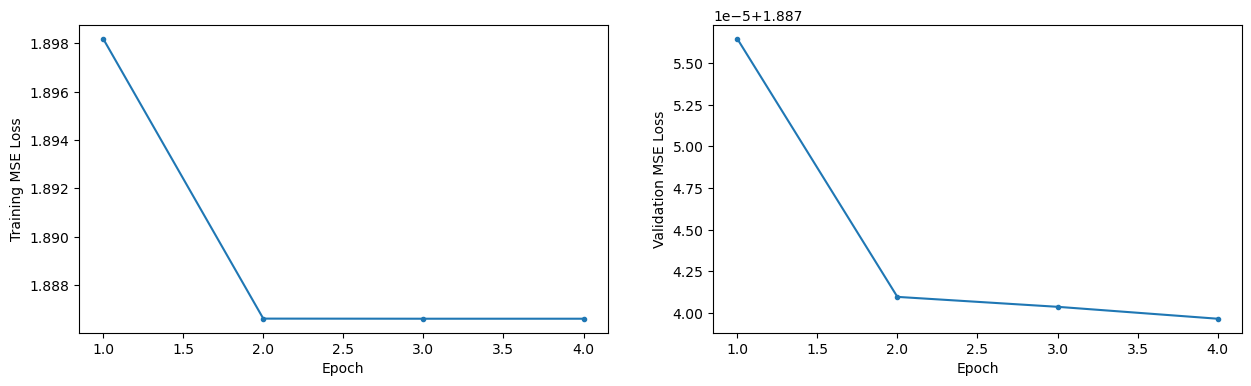

In [ ]:
def plot_training_metrics(trainer,metrics,ax):
    event_acc = EventAccumulator(trainer.logger.log_dir)
    event_acc.Reload()
    for i in range(len(metrics)):
        y=[i.value for i in event_acc.Scalars(metrics[i]['name'])]
        x=np.arange(len(y))+1
        ax[i].plot(x,y,marker='.')
        ax[i].set_xlabel("Epoch")
        ax[i].set_ylabel(metrics[i]['label'])
metrics=[{'name':'train_loss','label':'Training MSE Loss'},{'name':'val_loss','label':'Validation MSE Loss'}]
fig,ax = plt.subplots(ncols=len(metrics),figsize=(15,4))
plot_training_metrics(trainer,metrics,ax)

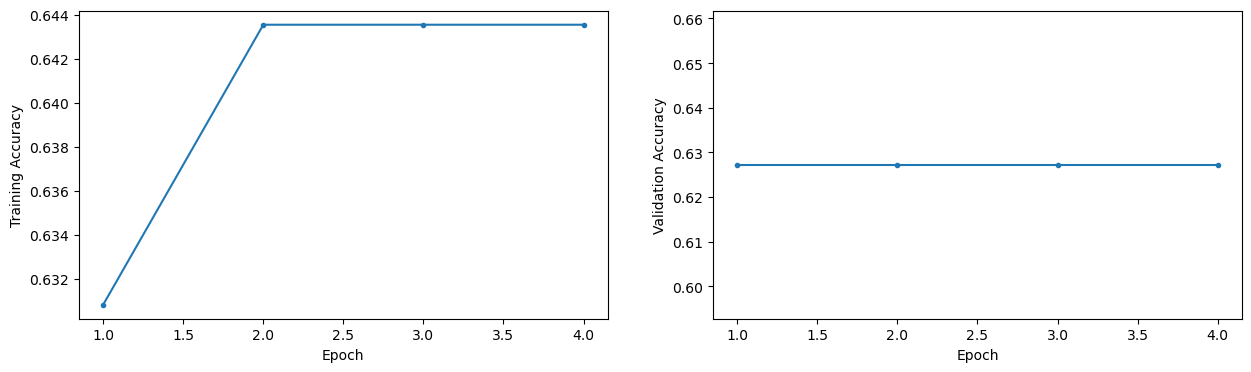

In [ ]:
metrics=[{'name':'train_accuracy','label':'Training Accuracy'},{'name':'val_accuracy','label':'Validation Accuracy'}]
fig,ax = plt.subplots(ncols=len(metrics),figsize=(15,4))
plot_training_metrics(trainer,metrics,ax)

In [ ]:
trainer.test(ckpt_path="best",dataloaders=test_loader)

Restoring states from the checkpoint path at /home/hwerneck/fast-ids/lightning_logs/version_15/checkpoints/iec104-epoch=03-loss=0.00.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/hwerneck/fast-ids/lightning_logs/version_15/checkpoints/iec104-epoch=03-loss=0.00.ckpt


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.654491126537323
        test_loss           1.8885499238967896
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.8885499238967896, 'test_accuracy': 0.654491126537323}]

In [ ]:
# class ImageFCN(nn.Module):
#     def __init__(self,fcn):
#         super(FVIT, self).__init__()
#         self.fcn = fcn

#     def forward(self, x):
#         return self.fcn(torch.flatten(x))
# ImageFCN(FullyConnectedNet())

In [ ]:
# MAX_EPOCHS=50
# # timer =  L.pytorch.calalbacks.Timer()
# def run_fvit_trainer_fit(train_loader,validation_loader,model):
#     checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
#         monitor='train_loss',
#         filename='iec104-{epoch:02d}-{loss:.2f}',
#         save_top_k=3,
#         mode='min',
#     )

#     early_stop_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, verbose=False, mode="min")
#     # cpb=CustomProgressBar()
#     trainer = L.Trainer(max_epochs=MAX_EPOCHS,callbacks=[checkpoint_callback,early_stop_callback],accelerator=DEVICE,
#                         devices=1,log_every_n_steps=10,limit_train_batches=0.1,limit_val_batches=0.1,max_time={"minutes": 5})
#     trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader)
#     return checkpoint_callback,trainer
# checkpoint_callback,trainer=run_fvit_trainer_fit(
#     train_loader,
#     validation_loader,
#      model=model_fvit)